Make sure you have the clips in data folder. They should be called:
- `1.MOV`
- `2.MOV`
- `3.MOV`
- `MEDIUM_1.MOV`
- `MEDIUM_2.MOV`
- `MEDIUM_3.MOV`
- `HARD_1.MOV`
- `HARD_2.MOV`
- `HARD_3.MOV`

In [2]:
import cv2
import numpy as np

from PIL import Image

In [3]:
clips = [
    '1.MOV',
    '2.MOV',
    '3.MOV',
    'MEDIUM_1.MOV',
    'MEDIUM_2.MOV',
    'MEDIUM_3.MOV',
    'HARD_1.MOV',
    'HARD_2.MOV',
    'HARD_3.MOV',
]

clips = [f'data/{clip}' for clip in clips]

In [4]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [5]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    if cap.isOpened():
        print('Opened the file successfully.')

    print(f"File name: {path}")
    # Height and width of the video
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

    print(f"Height: {height}, Width: {width}")

    # Number of frames in the video
    FPS = cap.get(cv2.CAP_PROP_FPS)
    print(f"FPS: {FPS}")

    return cap, int(height), int(width), FPS

In [6]:
test_video, test_height, test_width, test_FPS = load_video(clips[-1])

Opened the file successfully.
File name: data/test.mp4
Height: 1280.0, Width: 720.0
FPS: 25.0


In [7]:
def proper_opening(img, struct):
  transformed = cv2.morphologyEx(
      cv2.morphologyEx(
          cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct), cv2.MORPH_OPEN, struct
      ), cv2.MORPH_CLOSE, struct
  )

  return np.min(np.stack((transformed, img), axis=2), axis=2)

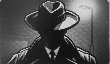

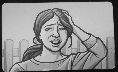

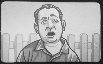

In [17]:
# pre process images used for reference
assassin = cv2.imread('data/assassin.jpg', cv2.IMREAD_COLOR)
neutral1 = cv2.imread('data/neutral1.jpg', cv2.IMREAD_COLOR)
neutral2 = cv2.imread('data/neutral2.jpg', cv2.IMREAD_COLOR)

# rotate left and downscale
assassin = cv2.rotate(assassin, cv2.ROTATE_90_COUNTERCLOCKWISE)
assassin = cv2.resize(assassin, (176, 120))
neutral1 = cv2.resize(neutral1, (176, 120))
neutral2 = cv2.resize(neutral2, (176, 120))

# remove background, leaving only the assassin

# find mask with the assassin
assassin_hsv = cv2.cvtColor(assassin, cv2.COLOR_BGR2HSV)
neutral1_hsv = cv2.cvtColor(neutral1, cv2.COLOR_BGR2HSV)
neutral2_hsv = cv2.cvtColor(neutral2, cv2.COLOR_BGR2HSV)
assassin_mask = cv2.inRange(assassin_hsv, (0, 0, 0), (100, 100, 100))
neutral1_mask = cv2.inRange(neutral1_hsv, (0, 10, 10), (50, 255, 255))
neutral2_mask = cv2.inRange(neutral2_hsv, (0, 10, 10), (50, 255, 255))


# apply opening to the mask
assassin_mask = proper_opening(assassin_mask, np.ones((7, 7), np.uint8))
neutral1_mask = proper_opening(neutral1_mask, np.ones((7, 7), np.uint8))
neutral2_mask = proper_opening(neutral2_mask, np.ones((7, 7), np.uint8))

# Keep only mask remove the rest from the
new_assassin = np.zeros_like(assassin)
new_neutral1 = np.zeros_like(neutral1)
new_neutral2 = np.zeros_like(neutral2)
new_assassin[assassin_mask == 255] = assassin[assassin_mask == 255]
new_neutral1[neutral1_mask == 255] = neutral1[neutral1_mask == 255]
new_neutral2[neutral2_mask == 255] = neutral2[neutral2_mask == 255]

# crop the black background
x, y, w, h = cv2.boundingRect(assassin_mask)
assassin = assassin[y:y+h, x:x+w]
x, y, w, h = cv2.boundingRect(neutral1_mask)
neutral1 = neutral1[y:y+h, x:x+w]
x, y, w, h = cv2.boundingRect(neutral2_mask)
neutral2 = neutral2[y:y+h, x:x+w]

# change to grayscale
assassin_gray = cv2.cvtColor(assassin, cv2.COLOR_BGR2GRAY)
neutral1_gray = cv2.cvtColor(neutral1, cv2.COLOR_BGR2GRAY)
neutral2_gray = cv2.cvtColor(neutral2, cv2.COLOR_BGR2GRAY)

imshow(assassin_gray)
imshow(neutral1_gray)
imshow(neutral2_gray)

In [29]:


def do_everything(input_file_path, output_file_path):
    video, height, width, FPS = load_video(input_file_path)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    output_video = cv2.VideoWriter(
        output_file_path,
        fourcc,
        FPS,
        (width, height),
        )

    # Create a background subtractor
    fgbg = cv2.createBackgroundSubtractorMOG2()


    frame_n = -1
    while video.isOpened():

        ret, frame = video.read()
        frame_n += 1
        if not ret:
            break
        # === Color Segmentation ===
        # Range of colors in HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # bounds for red and blue
        lower_red = np.array([0, 100, 100])
        upper_red = np.array([12, 255, 255])
        lower_blue = np.array([98, 50, 50])
        upper_blue = np.array([118, 255, 255])

        # Threshold the HSV image to get only predefined colors
        mask_red = cv2.inRange(hsv, lower_red, upper_red)
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

        # Combine masks
        mask = cv2.bitwise_or(mask_red, mask_blue)

        # apply proper opening
        mask = proper_opening(mask, np.ones((5, 5), np.uint8))
        # dilate mask to fill in holes
        mask = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=3)


        # Find contours and draw bounding boxes around detected elements
        contours_red_blue, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # === Hand Detection ===

        # find background
        fgmask = fgbg.apply(frame)

        # Remove noise
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
        fgmask = cv2.dilate(fgmask, None, iterations=2)

        contours_hand, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        if frame_n % 20 == 0:
            # === Key Point Detection ===
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            sift = cv2.SIFT_create()
            kp_frame, des_frame = sift.detectAndCompute(gray_frame, None)

            # === Assasin ===
            kp_assassin, des_assassin = sift.detectAndCompute(assassin_gray, None)
            bf = cv2.BFMatcher()

            matches = bf.knnMatch(des_assassin, des_frame,k=2)

            good = []
            for m,n in matches:
                if m.distance < 0.65*n.distance:
                    good.append([m])

            clusters = []
            for match in good:
                pt1 = kp_assassin[match[0].queryIdx].pt
                pt2 = kp_frame[match[0].trainIdx].pt
                added_to_cluster = False

                for cluster in clusters:
                    for point in cluster:
                        if np.linalg.norm(np.array(pt1) - np.array(point)) < 120:
                            cluster.append(pt2)
                            added_to_cluster = True
                            break

                    if added_to_cluster:
                        break

                if not added_to_cluster:
                    clusters.append([pt1, pt2])

            # === Neutral ===
            # sift = cv2.SIFT_create()
            kp_neutral1, des_neutral1 = sift.detectAndCompute(neutral1_gray, None)
            kp_neutral2, des_neutral2 = sift.detectAndCompute(neutral2_gray, None)


            bf = cv2.BFMatcher()

            matches_neutral1 = bf.knnMatch(des_neutral1,des_frame,k=2)
            matches_neutral2 = bf.knnMatch(des_neutral2,des_frame,k=2)

            good_neutral = []
            for m,n in matches_neutral1:
                if m.distance < 0.75*n.distance:
                    good_neutral.append([m])

            for m,n in matches_neutral2:
                if m.distance < 0.75*n.distance:
                    good_neutral.append([m])
            

            neutral_clusters = []
            for m in good_neutral:
                current_point = kp_frame[m[0].trainIdx].pt
                added_to_cluster = False

                for cluster in neutral_clusters:
                    for point in cluster:
                        distance = np.sqrt((point[0] - current_point[0])**2 + (point[1] - current_point[1])**2)
                        if distance < 70:
                            cluster.append(current_point)
                            added_to_cluster = True
                            break
                    if added_to_cluster:
                        break
                if not added_to_cluster:
                    neutral_clusters.append([current_point])


        # === Display ===
        # Display color segmentation detection results
        for contour in contours_red_blue:
            if cv2.contourArea(contour) < 1500 or cv2.contourArea(contour) > 50000:
                continue
            x, y, w, h = cv2.boundingRect(contour)

            cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)
            if np.sum(mask_blue[y:y+h, x:x+w]) > np.sum(mask_red[y:y+h, x:x+w]):
                cv2.putText(frame, 'Team Blue', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            elif np.sum(mask_blue[y:y+h, x:x+w]) < np.sum(mask_red[y:y+h, x:x+w]):
                cv2.putText(frame, 'Team Red', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # Display assasin
        for cluster in clusters:
            if len(cluster) < 4:
                continue
            # find middle point of the cluster
            middle_point = np.mean(cluster, axis=0)
            x, y = middle_point
            # draw circle around the middle point
            cv2.circle(frame, (int(x), int(y)), 70, (0, 0, 255), 2)
            cv2.putText(frame, 'Assasin', (int(x)-40, int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # Display neutral
        for cluster in neutral_clusters:
            if len(cluster) < 2:
                continue
            # find middle point of the cluster
            middle_point = np.mean(cluster, axis=0)
            x, y = middle_point
            # draw circle around the middle point
            cv2.circle(frame, (int(x), int(y)), 70, (255, 0, 0), 2)
            cv2.putText(frame, 'Neutral', (int(x)-40, int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)


        # Display hand detection results
        # We are assuming that hand is the biggest moving object in the frame.
        max_area = 0
        hand_box = None
        for contour in contours_hand:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                x, y, w, h = cv2.boundingRect(contour)
                hand_box = (x, y, x + w, y + h)

        if hand_box is not None and max_area > 50000:
            cv2.rectangle(frame, (hand_box[0], hand_box[1]), (hand_box[2], hand_box[3]), (0, 255, 0), 2)
            cv2.putText(frame, 'Picking card', (hand_box[0], hand_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        output_video.write(frame)

    video.release()  # Release the video capture
    output_video.release()

In [ ]:
!ffmpeg -hide_banner -loglevel error -i test_clip_foreground.avi -y test_clip_foreground.mp4

In [30]:
for clip in clips:
    do_everything(clip, f'outputs/{clip.split("/")[-1]}')
    print(f'Done with {clip}')

Opened the file successfully.
File name: data/1.MOV
Height: 1920.0, Width: 1080.0
FPS: 29.97002997002997
Done with data/1.MOV
Opened the file successfully.
File name: data/2.MOV
Height: 1920.0, Width: 1080.0
FPS: 29.97002997002997
Done with data/2.MOV
Opened the file successfully.
File name: data/3.MOV
Height: 1920.0, Width: 1080.0
FPS: 29.97002997002997
Done with data/3.MOV
Opened the file successfully.
File name: data/MEDIUM_1.MOV
Height: 1920.0, Width: 1080.0
FPS: 29.97002997002997
Done with data/MEDIUM_1.MOV
Opened the file successfully.
File name: data/MEDIUM_2.MOV
Height: 1920.0, Width: 1080.0
FPS: 29.97002997002997
Done with data/MEDIUM_2.MOV
Opened the file successfully.
File name: data/MEDIUM_3.MOV
Height: 1920.0, Width: 1080.0
FPS: 29.97002997002997
Done with data/MEDIUM_3.MOV
Opened the file successfully.
File name: data/HARD_1.MOV
Height: 1920.0, Width: 1080.0
FPS: 29.97002997002997
Done with data/HARD_1.MOV
Opened the file successfully.
File name: data/HARD_2.MOV
Height: 1